In [1]:
from collections import Counter
import sys
import time
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model

In [2]:
from google.colab import files
uploaded = files.upload()

Saving final_imu_data.csv to final_imu_data.csv
Saving imu_1.csv to imu_1.csv
Saving pulse_1.csv to pulse_1.csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['imu_1.csv']))
dfp = pd.read_csv(io.BytesIO(uploaded['pulse_1.csv']))
dff = pd.read_csv(io.BytesIO(uploaded['final_imu_data.csv']))

In [4]:
df['time'] = pd.to_datetime(df['time'])
df['time'] = pd.Series([val.time() for val in df['time']])
df.head(5)

,time,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro,x_mag,y_mag,z_mag,rem
0,01:40:41,-136.96,-3.91,865.36,-0.092,0.114,-0.114,188.64,62.52,-5.13,0
1,01:40:42,-133.85,-0.61,863.95,-0.092,0.458,-0.130,200.98,57.16,-3.42,0
2,01:40:42,-142.03,-7.08,865.97,-0.389,0.397,-0.275,186.87,67.88,0.00,0
3,01:40:43,-137.76,1.46,861.88,-0.198,0.381,0.031,190.40,57.16,0.00,0
4,01:40:43,-137.21,-3.48,862.06,-0.443,0.221,0.023,183.35,60.74,-13.68,0


In [5]:
df1 = dff.head(15000).loc[df['rem'] == 1]
df1.head(5)
print(df1['time'].size)

1306


In [6]:
df1 = df1.drop(columns=['time', 'x_mag', 'y_mag', 'z_mag', 'rem'])
df1.head(5)

,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
12983,-169.68,-113.77,903.08,0.191,0.542,-0.061
12984,-168.46,-112.92,901.43,0.031,0.313,0.015
12985,-170.72,-112.55,901.79,-0.153,-0.343,-0.015
12986,-175.54,-122.19,905.94,-0.641,-0.679,-0.420
12987,-157.71,-131.41,897.22,-0.023,-1.274,-0.473


Plotting Data for a sample night 

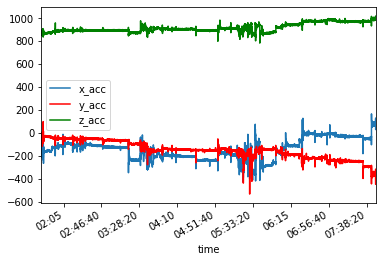

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df.plot(kind='line',x='time',y='x_acc',ax=ax)
df.plot(kind='line',x='time',y='y_acc', color='red', ax=ax)
df.plot(kind='line',x='time',y='z_acc', color='green', ax=ax)
fig.autofmt_xdate() 
plt.show()

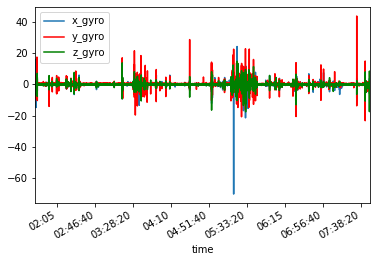

In [60]:
fig, ax2 = plt.subplots()
df.plot(kind='line',x='time',y='x_gyro',ax=ax2)
df.plot(kind='line',x='time',y='y_gyro', color='red', ax=ax2)
df.plot(kind='line',x='time',y='z_gyro', color='green', ax=ax2)
fig.autofmt_xdate() 
plt.show()

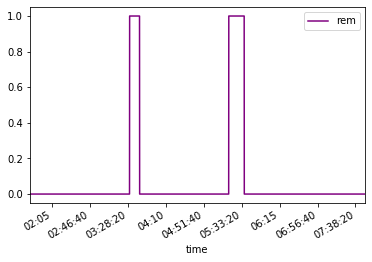

In [55]:
fig, ax = plt.subplots()
df.plot(kind='line',x='time',y='rem', color='purple', ax=ax)
fig.autofmt_xdate() 
plt.show()

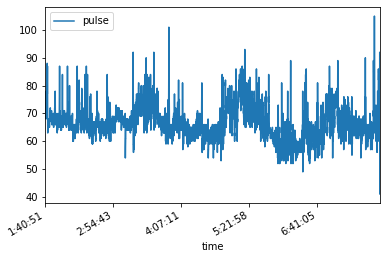

In [63]:
fig, ax = plt.subplots()
dfp.plot(kind='line',x='time',y='pulse', ax=ax)
fig.autofmt_xdate() 
plt.show()

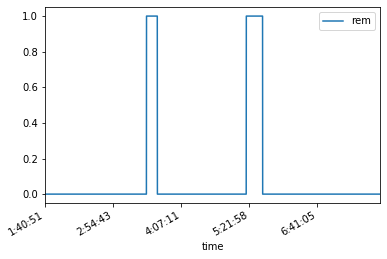

In [64]:
fig, ax = plt.subplots()
dfp.plot(kind='line', x='time', y='rem', ax=ax)
fig.autofmt_xdate()
plt.show()

In [0]:
#create training np array for REM sleep
X_train = np.zeros((80,512,6))
j = 0
while j < 80: #794:
  k = 0
  while k < 512:
    X_train[j][k][0] = df1['x_acc'].values[k+j]
    X_train[j][k][1] = df1['y_acc'].values[k+j]
    X_train[j][k][2] = df1['z_acc'].values[k+j]
    X_train[j][k][3] = df1['x_gyro'].values[k+j]
    X_train[j][k][4] = df1['y_gyro'].values[k+j]
    X_train[j][k][5] = df1['z_gyro'].values[k+j]
    k = k+1
  j = j+1

In [10]:
df2 = dff.tail(20000).loc[df['rem'] == 1]
df2.head(5)
print(df2['time'].size)

2022


In [11]:
df2 = df2.drop(columns=['time', 'x_mag', 'y_mag', 'z_mag', 'rem'])
df2.head(5)

,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
25928,-266.30,-178.96,888.55,0.473,-2.617,-0.763
25929,-252.75,-172.30,899.90,0.587,1.526,0.237
25930,-258.00,-184.75,893.74,0.275,0.648,-0.603
25931,-287.54,-182.31,879.88,-0.153,1.434,-0.099
25932,-304.93,-179.69,875.31,-0.031,-0.237,0.069


In [0]:
#populate remaining REM sleep data
X_train2 = np.zeros((130,512,6))
j = 0
while j < 130:
  k = 0
  while k < 512:
    X_train2[j][k][0] = df2['x_acc'].values[k+j]
    X_train2[j][k][1] = df2['y_acc'].values[k+j]
    X_train2[j][k][2] = df2['z_acc'].values[k+j]
    X_train2[j][k][3] = df2['x_gyro'].values[k+j]
    X_train2[j][k][4] = df2['y_gyro'].values[k+j]
    X_train2[j][k][5] = df2['z_gyro'].values[k+j]
    k = k+1
  j = j+1

In [14]:
X_train_fin = np.concatenate((X_train, X_train2))
print(X_train_fin.shape)

(210, 512, 6)


In [0]:
#label REM sleep
y_fin = np.ones((210,1))

Adding Non-REM data

In [16]:
dfn = dff.head(11000)
dfn_seg = dfn.tail(5000)
dfn_seg = dfn_seg.drop(columns=['time', 'x_mag', 'y_mag', 'z_mag', 'rem'])
dfn_seg.head(5)

,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
6000,-104.37,-48.28,896.12,0.061,0.252,-0.015
6001,-104.55,-48.52,895.45,-0.076,0.290,-0.114
6002,-105.29,-46.39,892.82,0.076,0.206,-0.061
6003,-102.72,-44.07,890.87,0.015,0.214,-0.015
6004,-99.91,-46.75,888.67,0.092,0.175,0.061


In [0]:
dfn = dff.tail(10000)
dfn.head(5)
dfn_seg = dfn.drop(columns=['time', 'x_mag', 'y_mag', 'z_mag', 'rem'])

In [0]:
#populate array of non REM sleep
X_train_n = np.zeros((210,512,6))
j = 0
while j < 210:
  k = 0
  l = 0
  while k < 512:
    X_train_n[j][k][0] = dfn_seg['x_acc'].values[l+j]
    X_train_n[j][k][1] = dfn_seg['y_acc'].values[l+j]
    X_train_n[j][k][2] = dfn_seg['z_acc'].values[l+j]
    X_train_n[j][k][3] = dfn_seg['x_gyro'].values[l+j]
    X_train_n[j][k][4] = dfn_seg['y_gyro'].values[l+j]
    X_train_n[j][k][5] = dfn_seg['z_gyro'].values[l+j]
    k = k+1
    l = k+1
  j = j+1

In [0]:
#label non REM data
y_fin_n = np.zeros((210,1))

In [21]:
y = np.concatenate((y_fin, y_fin_n))
print(y.shape)

(420, 1)


In [22]:
X = np.concatenate((X_train_fin, X_train_n))
print(X.shape)

(420, 512, 6)


In [0]:
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test0, X_val0, y_test, y_val = train_test_split(X_test0, y_test, test_size=0.5)

In [88]:
print(X_val0.shape)
print(X_test0.shape)
print(X_train0.shape)

(63, 512, 6)
(63, 512, 6)
(294, 512, 6)


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Permute, Reshape
def model_ConvLSTM(dim, win_len, num_classes, num_feat_map=64, p=0.3, batchnorm=True, dropout=True):
    model = Sequential(name='ConvLSTM')
    model.add(Conv2D(num_feat_map, kernel_size=(1, 3),
                     activation='relu',
                     input_shape=(dim, win_len, 1),
                     padding='same', name='Conv_1'))
    if batchnorm:
        model.add(BatchNormalization(name='Bn_1'))
    model.add(MaxPooling2D(pool_size=(1, 2), name='Max_pool_1'))
    if dropout:
        model.add(Dropout(p, name='Drop_1'))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 3),
                     activation='relu', padding='same', name='Conv_2'))
    if batchnorm:
        model.add(BatchNormalization(name='Bn_2'))
    model.add(MaxPooling2D(pool_size=(1, 2), name='Max_pool_2'))
    if dropout:
        model.add(Dropout(p, name='Drop_2'))
    model.add(Permute((2, 1, 3), name='Permute_1'))  # for swap-dimension
    model.add(Reshape((-1, num_feat_map * dim), name='Reshape_1'))
    model.add(LSTM(32, return_sequences=False, stateful=False, name='Lstm_1'))
    if dropout:
        model.add(Dropout(p, name='Drop_3'))
    model.add(Dense(num_classes, activation='softmax', name='dense_out'))
    return model

In [0]:
def reshape_data(X_tr, X_va, X_tst, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)

    if network_type == 'CNN' or network_type == 'ConvLSTM':
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_tr = np.swapaxes(X_tr, 1, 2)
        X_va = np.swapaxes(X_va, 1, 2)
        X_tst = np.swapaxes(X_tst, 1, 2)

        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
        X_tst = np.reshape(X_tst, (-1, dim, win_len, 1))

    elif network_type == 'MLP':
        X_tr = np.reshape(X_tr, (-1, dim * win_len))
        X_va = np.reshape(X_va, (-1, dim * win_len))
        X_tst = np.reshape(X_tst, (-1, dim * win_len))

    return X_tr, X_va, X_tst

In [108]:
X_train, X_val, X_test = reshape_data(X_train0, X_val0, X_test0, 'ConvLSTM')

ConvLSTM


Specify Hyperparameters

In [0]:
batch_size = 256
_, win_len, dim = X_train0.shape

In [109]:
model = model_ConvLSTM(dim, win_len, 2, num_feat_map=32, p=0.3)
print(model.summary())

Model: "ConvLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 6, 512, 32)        128       
_________________________________________________________________
Bn_1 (BatchNormalization)    (None, 6, 512, 32)        128       
_________________________________________________________________
Max_pool_1 (MaxPooling2D)    (None, 6, 256, 32)        0         
_________________________________________________________________
Drop_1 (Dropout)             (None, 6, 256, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 6, 256, 32)        3104      
_________________________________________________________________
Bn_2 (BatchNormalization)    (None, 6, 256, 32)        128       
_________________________________________________________________
Max_pool_2 (MaxPooling2D)    (None, 6, 128, 32)        0  

In [0]:
epochs = 5
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [111]:
model.fit(X_train, y_train,
          batch_size=300,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          validation_data=(X_val, y_val))

Train on 294 samples, validate on 63 samples
Epoch 1/5
294/294 [==============================] - 4s 15ms/sample - loss: 0.7553 - acc: 0.5068 - val_loss: 0.8677 - val_acc: 0.4921
Epoch 2/5
294/294 [==============================] - 3s 9ms/sample - loss: 0.6733 - acc: 0.5578 - val_loss: 0.8246 - val_acc: 0.4921
Epoch 3/5
294/294 [==============================] - 3s 9ms/sample - loss: 0.6079 - acc: 0.6293 - val_loss: 0.6939 - val_acc: 0.4921
Epoch 4/5
294/294 [==============================] - 3s 9ms/sample - loss: 0.5163 - acc: 0.7925 - val_loss: 0.6284 - val_acc: 0.6825
Epoch 5/5
294/294 [==============================] - 3s 9ms/sample - loss: 0.4797 - acc: 0.7993 - val_loss: 0.6233 - val_acc: 0.8730


In [0]:
#update prediction results to compute confusion matrix
y_out = model.predict(X_test)

y_res = np.zeros((63,1))
i = 0
while i < 63:
  temp = y_out[i][1]
  if temp > 0.5:
    y_res[i][0] = 1
  else:
    y_res[i][0] = 0
  i = i+1

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_res)

In [113]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
print(cf_matrix)
class_wise_f1 = f1_score(y_test, y_res, average=None)
print('the mean-f1 score: {:.4f}'.format(np.mean(class_wise_f1)))
accuracy = accuracy_score(y_test, y_res)
print('accuracy is: {:.4f}'.format(accuracy))

[[30  0]
 [ 5 28]]
the mean-f1 score: 0.9206
accuracy is: 0.9206
